In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
data_set = datasets.CIFAR10(root="./data", download=True, transform=transforms.Compose([
    transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = 128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

noise_dimension = 100 

real_value = 1 

fake_value = 0 


rand_seed = random.randint(10, 100000)
random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [4]:
def weights_initialize(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, passed_input):
        discriminator_output = self.main(passed_input)
        return discriminator_output.view(-1, 1).squeeze(1)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dimension, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, passed_input):
        generator_output = self.main(passed_input)
        return generator_output

In [7]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator.apply(weights_initialize)
generator.apply(weights_initialize)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
noise = torch.randn(128, noise_dimension, 1, 1, device=device)
gen_loss_list = []
dis_loss_list = []
counter = 0
counter_list = []

In [9]:
num_epochs = 10
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader, 0):
        counter += 1
        counter_list.append(counter)
        
       
        real_data = data[0].to(device)
        size_of_batch = real_data.size(0)
        labels_tensor = torch.full((size_of_batch,), real_value, device = device).float()
        discriminator.zero_grad()
        dis_output = discriminator(real_data ).float()
        dis_real_error = criterion(dis_output, labels_tensor)
        dis_real_error.backward()
        dis_real_output_mean = dis_output.mean().item()

        
        labels_tensor.fill_(fake_value).float()
        noise = torch.randn(size_of_batch, noise_dimension, 1, 1, device=device)
        fake_data = generator(noise)
        dis_output = discriminator(fake_data.detach()).float()
        dis_fake_error = criterion(dis_output, labels_tensor)
        dis_fake_error.backward()
        dis_fake_output_mean = dis_output.mean().item()
        disriminator_optimizer.step()
        final_dis_error = dis_real_error + dis_fake_error
        dis_loss_list.append(final_dis_error.item())
        

       
        labels_tensor.fill_(real_value).float()
        generator.zero_grad()
        gen_output = discriminator(fake_data).float()
        gen_error = criterion(gen_output, labels_tensor)
        gen_loss_list.append(gen_error.item())
        gen_error.backward()
        gen_output_mean = gen_output.mean().item()
        generator_optimizer.step()

        
        print('[%d/%d][%d/%d] DisLoss: %.4f GenLoss: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % 
              (epoch, num_epochs, i, len(data_loader), final_dis_error.item(), 
               gen_error.item(), dis_real_output_mean, dis_fake_output_mean, gen_output_mean ))
        
  
    fake_data = generator(noise)
    vutils.save_image(real_data,'DCganOutput/real_samples.png',normalize=True)
    vutils.save_image(fake_data.detach(),'DCganOutput/fake_samples_epoch_%03d.png' % (epoch), normalize=True)

[0/10][0/391] DisLoss: 1.4370 GenLoss: 6.2397 D(x): 0.5562 D(G(z)): 0.4747 / 0.0031
[0/10][1/391] DisLoss: 1.0929 GenLoss: 5.4521 D(x): 0.6519 D(G(z)): 0.3328 / 0.0066
[0/10][2/391] DisLoss: 1.0004 GenLoss: 6.1898 D(x): 0.7862 D(G(z)): 0.4337 / 0.0039
[0/10][3/391] DisLoss: 0.9758 GenLoss: 6.6058 D(x): 0.7249 D(G(z)): 0.3608 / 0.0021
[0/10][4/391] DisLoss: 0.8307 GenLoss: 7.0457 D(x): 0.7345 D(G(z)): 0.3094 / 0.0017
[0/10][5/391] DisLoss: 0.9317 GenLoss: 6.9888 D(x): 0.6848 D(G(z)): 0.2711 / 0.0016
[0/10][6/391] DisLoss: 0.8909 GenLoss: 8.2443 D(x): 0.7673 D(G(z)): 0.3578 / 0.0005
[0/10][7/391] DisLoss: 0.6518 GenLoss: 8.1698 D(x): 0.7765 D(G(z)): 0.2211 / 0.0005
[0/10][8/391] DisLoss: 0.5684 GenLoss: 9.0125 D(x): 0.8346 D(G(z)): 0.2648 / 0.0002
[0/10][9/391] DisLoss: 0.6025 GenLoss: 9.4442 D(x): 0.7943 D(G(z)): 0.2221 / 0.0001
[0/10][10/391] DisLoss: 0.6987 GenLoss: 9.9249 D(x): 0.7426 D(G(z)): 0.2360 / 0.0001
[0/10][11/391] DisLoss: 0.5288 GenLoss: 10.3232 D(x): 0.8065 D(G(z)): 0.198

[0/10][97/391] DisLoss: 0.5566 GenLoss: 10.9887 D(x): 0.9344 D(G(z)): 0.3588 / 0.0003
[0/10][98/391] DisLoss: 1.5083 GenLoss: 5.0101 D(x): 0.4709 D(G(z)): 0.0028 / 0.0116
[0/10][99/391] DisLoss: 0.4201 GenLoss: 5.2786 D(x): 0.8683 D(G(z)): 0.1787 / 0.0384
[0/10][100/391] DisLoss: 0.6694 GenLoss: 9.1548 D(x): 0.8689 D(G(z)): 0.3171 / 0.0003
[0/10][101/391] DisLoss: 1.2981 GenLoss: 3.7377 D(x): 0.5143 D(G(z)): 0.0090 / 0.0397
[0/10][102/391] DisLoss: 0.6834 GenLoss: 7.4301 D(x): 0.9702 D(G(z)): 0.4224 / 0.0020
[0/10][103/391] DisLoss: 0.2717 GenLoss: 6.1205 D(x): 0.8590 D(G(z)): 0.0422 / 0.0052
[0/10][104/391] DisLoss: 0.3936 GenLoss: 3.4840 D(x): 0.8215 D(G(z)): 0.1201 / 0.0545
[0/10][105/391] DisLoss: 0.7594 GenLoss: 7.1279 D(x): 0.9343 D(G(z)): 0.4325 / 0.0034
[0/10][106/391] DisLoss: 0.7465 GenLoss: 5.2057 D(x): 0.6169 D(G(z)): 0.0296 / 0.0126
[0/10][107/391] DisLoss: 0.2282 GenLoss: 4.0308 D(x): 0.9112 D(G(z)): 0.0999 / 0.0226
[0/10][108/391] DisLoss: 0.2976 GenLoss: 5.4547 D(x): 0.

[0/10][193/391] DisLoss: 0.2164 GenLoss: 5.7113 D(x): 0.9043 D(G(z)): 0.0936 / 0.0049
[0/10][194/391] DisLoss: 0.1805 GenLoss: 5.8964 D(x): 0.9295 D(G(z)): 0.0907 / 0.0039
[0/10][195/391] DisLoss: 0.1954 GenLoss: 5.8389 D(x): 0.9109 D(G(z)): 0.0788 / 0.0047
[0/10][196/391] DisLoss: 0.1276 GenLoss: 6.1493 D(x): 0.9646 D(G(z)): 0.0826 / 0.0036
[0/10][197/391] DisLoss: 0.1756 GenLoss: 5.3738 D(x): 0.9053 D(G(z)): 0.0551 / 0.0066
[0/10][198/391] DisLoss: 0.1418 GenLoss: 6.4586 D(x): 0.9689 D(G(z)): 0.0994 / 0.0023
[0/10][199/391] DisLoss: 0.1514 GenLoss: 5.6557 D(x): 0.9124 D(G(z)): 0.0399 / 0.0048
[0/10][200/391] DisLoss: 0.1284 GenLoss: 5.4574 D(x): 0.9531 D(G(z)): 0.0685 / 0.0054
[0/10][201/391] DisLoss: 0.1342 GenLoss: 6.4503 D(x): 0.9668 D(G(z)): 0.0901 / 0.0021
[0/10][202/391] DisLoss: 0.1081 GenLoss: 5.8523 D(x): 0.9386 D(G(z)): 0.0324 / 0.0037
[0/10][203/391] DisLoss: 0.1177 GenLoss: 5.4103 D(x): 0.9517 D(G(z)): 0.0557 / 0.0058
[0/10][204/391] DisLoss: 0.1837 GenLoss: 6.3019 D(x): 

[0/10][289/391] DisLoss: 1.0859 GenLoss: 14.0994 D(x): 0.9657 D(G(z)): 0.5893 / 0.0000
[0/10][290/391] DisLoss: 3.4853 GenLoss: 7.2044 D(x): 0.0934 D(G(z)): 0.0001 / 0.0091
[0/10][291/391] DisLoss: 0.2932 GenLoss: 4.4549 D(x): 0.9190 D(G(z)): 0.1065 / 0.0487
[0/10][292/391] DisLoss: 0.7926 GenLoss: 7.8481 D(x): 0.9399 D(G(z)): 0.3923 / 0.0024
[0/10][293/391] DisLoss: 1.0114 GenLoss: 4.1101 D(x): 0.6032 D(G(z)): 0.0303 / 0.0577
[0/10][294/391] DisLoss: 0.4922 GenLoss: 6.7144 D(x): 0.9665 D(G(z)): 0.2793 / 0.0057
[0/10][295/391] DisLoss: 0.3267 GenLoss: 7.0466 D(x): 0.9067 D(G(z)): 0.1325 / 0.0043
[0/10][296/391] DisLoss: 0.3253 GenLoss: 4.6432 D(x): 0.8227 D(G(z)): 0.0428 / 0.0239
[0/10][297/391] DisLoss: 0.2873 GenLoss: 5.6604 D(x): 0.9396 D(G(z)): 0.1621 / 0.0083
[0/10][298/391] DisLoss: 0.2797 GenLoss: 6.5213 D(x): 0.9119 D(G(z)): 0.1275 / 0.0036
[0/10][299/391] DisLoss: 0.2419 GenLoss: 5.7975 D(x): 0.8866 D(G(z)): 0.0780 / 0.0054
[0/10][300/391] DisLoss: 0.2843 GenLoss: 7.2412 D(x):

[0/10][385/391] DisLoss: 0.9962 GenLoss: 2.3464 D(x): 0.4779 D(G(z)): 0.0126 / 0.1588
[0/10][386/391] DisLoss: 0.7116 GenLoss: 6.2797 D(x): 0.9783 D(G(z)): 0.4502 / 0.0036
[0/10][387/391] DisLoss: 0.6450 GenLoss: 3.8366 D(x): 0.6702 D(G(z)): 0.0477 / 0.0429
[0/10][388/391] DisLoss: 0.5466 GenLoss: 4.3602 D(x): 0.8857 D(G(z)): 0.2669 / 0.0325
[0/10][389/391] DisLoss: 0.5269 GenLoss: 4.9416 D(x): 0.8533 D(G(z)): 0.2331 / 0.0141
[0/10][390/391] DisLoss: 0.7317 GenLoss: 2.9024 D(x): 0.6830 D(G(z)): 0.1257 / 0.0990
[1/10][0/391] DisLoss: 0.6936 GenLoss: 5.7010 D(x): 0.8879 D(G(z)): 0.3738 / 0.0058
[1/10][1/391] DisLoss: 0.8505 GenLoss: 2.2404 D(x): 0.5627 D(G(z)): 0.0434 / 0.2007
[1/10][2/391] DisLoss: 0.9896 GenLoss: 5.4576 D(x): 0.8532 D(G(z)): 0.4193 / 0.0246
[1/10][3/391] DisLoss: 0.8306 GenLoss: 3.7383 D(x): 0.6215 D(G(z)): 0.0707 / 0.0530
[1/10][4/391] DisLoss: 0.3169 GenLoss: 3.8110 D(x): 0.9163 D(G(z)): 0.1771 / 0.0494
[1/10][5/391] DisLoss: 0.4833 GenLoss: 5.3528 D(x): 0.8843 D(G(z

[1/10][91/391] DisLoss: 0.2419 GenLoss: 5.2570 D(x): 0.9218 D(G(z)): 0.1369 / 0.0075
[1/10][92/391] DisLoss: 0.2560 GenLoss: 4.1015 D(x): 0.8437 D(G(z)): 0.0565 / 0.0235
[1/10][93/391] DisLoss: 0.2530 GenLoss: 6.1846 D(x): 0.9451 D(G(z)): 0.1651 / 0.0033
[1/10][94/391] DisLoss: 0.1789 GenLoss: 4.9638 D(x): 0.8820 D(G(z)): 0.0387 / 0.0101
[1/10][95/391] DisLoss: 0.2292 GenLoss: 3.8939 D(x): 0.8822 D(G(z)): 0.0824 / 0.0275
[1/10][96/391] DisLoss: 0.3452 GenLoss: 7.7422 D(x): 0.9419 D(G(z)): 0.2351 / 0.0007
[1/10][97/391] DisLoss: 0.4285 GenLoss: 4.5415 D(x): 0.7213 D(G(z)): 0.0074 / 0.0190
[1/10][98/391] DisLoss: 0.3298 GenLoss: 5.7758 D(x): 0.9335 D(G(z)): 0.1987 / 0.0051
[1/10][99/391] DisLoss: 0.1466 GenLoss: 5.2241 D(x): 0.9143 D(G(z)): 0.0485 / 0.0098
[1/10][100/391] DisLoss: 0.2975 GenLoss: 4.3976 D(x): 0.8595 D(G(z)): 0.1122 / 0.0157
[1/10][101/391] DisLoss: 0.3277 GenLoss: 5.9851 D(x): 0.8968 D(G(z)): 0.1795 / 0.0036
[1/10][102/391] DisLoss: 0.2922 GenLoss: 3.9218 D(x): 0.8096 D(

[1/10][187/391] DisLoss: 0.3313 GenLoss: 5.3468 D(x): 0.8995 D(G(z)): 0.1632 / 0.0079
[1/10][188/391] DisLoss: 0.4068 GenLoss: 5.7537 D(x): 0.8300 D(G(z)): 0.1602 / 0.0046
[1/10][189/391] DisLoss: 0.3737 GenLoss: 4.6406 D(x): 0.8035 D(G(z)): 0.1205 / 0.0142
[1/10][190/391] DisLoss: 0.8661 GenLoss: 8.2467 D(x): 0.8540 D(G(z)): 0.4595 / 0.0004
[1/10][191/391] DisLoss: 0.9939 GenLoss: 2.5578 D(x): 0.4607 D(G(z)): 0.0122 / 0.1436
[1/10][192/391] DisLoss: 1.1412 GenLoss: 7.8624 D(x): 0.9490 D(G(z)): 0.5730 / 0.0017
[1/10][193/391] DisLoss: 0.8043 GenLoss: 2.3146 D(x): 0.5932 D(G(z)): 0.0234 / 0.1569
[1/10][194/391] DisLoss: 1.2336 GenLoss: 10.2773 D(x): 0.9606 D(G(z)): 0.6325 / 0.0002
[1/10][195/391] DisLoss: 1.5817 GenLoss: 5.5252 D(x): 0.3143 D(G(z)): 0.0026 / 0.0129
[1/10][196/391] DisLoss: 0.1686 GenLoss: 2.8445 D(x): 0.9345 D(G(z)): 0.0789 / 0.0984
[1/10][197/391] DisLoss: 0.6754 GenLoss: 5.9515 D(x): 0.9776 D(G(z)): 0.4134 / 0.0056
[1/10][198/391] DisLoss: 0.1407 GenLoss: 6.3686 D(x):

[1/10][283/391] DisLoss: 0.1534 GenLoss: 5.1762 D(x): 0.9472 D(G(z)): 0.0764 / 0.0095
[1/10][284/391] DisLoss: 0.3630 GenLoss: 4.0407 D(x): 0.8288 D(G(z)): 0.0991 / 0.0297
[1/10][285/391] DisLoss: 0.3249 GenLoss: 5.9805 D(x): 0.9244 D(G(z)): 0.1951 / 0.0039
[1/10][286/391] DisLoss: 0.3009 GenLoss: 4.2407 D(x): 0.8100 D(G(z)): 0.0418 / 0.0244
[1/10][287/391] DisLoss: 0.2621 GenLoss: 3.2449 D(x): 0.8746 D(G(z)): 0.1008 / 0.0542
[1/10][288/391] DisLoss: 0.3755 GenLoss: 6.5610 D(x): 0.9568 D(G(z)): 0.2513 / 0.0030
[1/10][289/391] DisLoss: 0.2876 GenLoss: 5.1901 D(x): 0.8008 D(G(z)): 0.0182 / 0.0120
[1/10][290/391] DisLoss: 0.2292 GenLoss: 3.4073 D(x): 0.8585 D(G(z)): 0.0461 / 0.0463
[1/10][291/391] DisLoss: 0.9970 GenLoss: 7.8911 D(x): 0.9772 D(G(z)): 0.5554 / 0.0014
[1/10][292/391] DisLoss: 2.5066 GenLoss: 2.7674 D(x): 0.2255 D(G(z)): 0.0075 / 0.1312
[1/10][293/391] DisLoss: 0.6531 GenLoss: 2.1782 D(x): 0.7810 D(G(z)): 0.2566 / 0.1964
[1/10][294/391] DisLoss: 0.8054 GenLoss: 6.5586 D(x): 

[1/10][379/391] DisLoss: 0.0910 GenLoss: 5.4171 D(x): 0.9454 D(G(z)): 0.0262 / 0.0078
[1/10][380/391] DisLoss: 0.1687 GenLoss: 3.9743 D(x): 0.8840 D(G(z)): 0.0282 / 0.0291
[1/10][381/391] DisLoss: 0.1926 GenLoss: 4.8947 D(x): 0.9829 D(G(z)): 0.1539 / 0.0103
[1/10][382/391] DisLoss: 0.1193 GenLoss: 4.8431 D(x): 0.9308 D(G(z)): 0.0391 / 0.0099
[1/10][383/391] DisLoss: 0.1318 GenLoss: 4.4967 D(x): 0.9517 D(G(z)): 0.0727 / 0.0141
[1/10][384/391] DisLoss: 0.2145 GenLoss: 4.1920 D(x): 0.9000 D(G(z)): 0.0913 / 0.0204
[1/10][385/391] DisLoss: 0.3787 GenLoss: 4.5690 D(x): 0.8637 D(G(z)): 0.1599 / 0.0146
[1/10][386/391] DisLoss: 0.2261 GenLoss: 4.4990 D(x): 0.9010 D(G(z)): 0.0959 / 0.0150
[1/10][387/391] DisLoss: 0.2908 GenLoss: 3.4867 D(x): 0.8543 D(G(z)): 0.0942 / 0.0421
[1/10][388/391] DisLoss: 0.2212 GenLoss: 4.7475 D(x): 0.9552 D(G(z)): 0.1490 / 0.0125
[1/10][389/391] DisLoss: 0.3636 GenLoss: 3.9273 D(x): 0.8342 D(G(z)): 0.1398 / 0.0261
[1/10][390/391] DisLoss: 0.3281 GenLoss: 4.1661 D(x): 

[2/10][85/391] DisLoss: 1.0875 GenLoss: 3.4528 D(x): 0.4663 D(G(z)): 0.0178 / 0.0717
[2/10][86/391] DisLoss: 0.6130 GenLoss: 4.1972 D(x): 0.9318 D(G(z)): 0.3347 / 0.0419
[2/10][87/391] DisLoss: 0.5141 GenLoss: 5.5426 D(x): 0.9073 D(G(z)): 0.2816 / 0.0083
[2/10][88/391] DisLoss: 0.8146 GenLoss: 2.4420 D(x): 0.6022 D(G(z)): 0.1125 / 0.1429
[2/10][89/391] DisLoss: 0.9821 GenLoss: 6.4277 D(x): 0.9445 D(G(z)): 0.5393 / 0.0029
[2/10][90/391] DisLoss: 0.7179 GenLoss: 4.2243 D(x): 0.5781 D(G(z)): 0.0224 / 0.0246
[2/10][91/391] DisLoss: 0.5241 GenLoss: 3.9208 D(x): 0.8638 D(G(z)): 0.2473 / 0.0312
[2/10][92/391] DisLoss: 0.7051 GenLoss: 6.6238 D(x): 0.8829 D(G(z)): 0.3575 / 0.0046
[2/10][93/391] DisLoss: 0.6740 GenLoss: 3.8776 D(x): 0.6212 D(G(z)): 0.0384 / 0.0571
[2/10][94/391] DisLoss: 0.8840 GenLoss: 6.2485 D(x): 0.8951 D(G(z)): 0.4417 / 0.0035
[2/10][95/391] DisLoss: 0.4949 GenLoss: 4.8803 D(x): 0.7310 D(G(z)): 0.0628 / 0.0212
[2/10][96/391] DisLoss: 0.5028 GenLoss: 5.4095 D(x): 0.8822 D(G(z

[2/10][181/391] DisLoss: 0.3972 GenLoss: 3.5589 D(x): 0.8194 D(G(z)): 0.1374 / 0.0433
[2/10][182/391] DisLoss: 0.4724 GenLoss: 5.4014 D(x): 0.8996 D(G(z)): 0.2602 / 0.0074
[2/10][183/391] DisLoss: 0.5115 GenLoss: 2.9621 D(x): 0.6948 D(G(z)): 0.0577 / 0.0838
[2/10][184/391] DisLoss: 0.5132 GenLoss: 5.6183 D(x): 0.9370 D(G(z)): 0.3146 / 0.0062
[2/10][185/391] DisLoss: 0.3557 GenLoss: 3.9347 D(x): 0.7817 D(G(z)): 0.0460 / 0.0302
[2/10][186/391] DisLoss: 0.7238 GenLoss: 3.8799 D(x): 0.7644 D(G(z)): 0.2942 / 0.0372
[2/10][187/391] DisLoss: 0.8375 GenLoss: 5.3652 D(x): 0.7509 D(G(z)): 0.3336 / 0.0086
[2/10][188/391] DisLoss: 0.5428 GenLoss: 2.0873 D(x): 0.6845 D(G(z)): 0.0609 / 0.2099
[2/10][189/391] DisLoss: 0.7725 GenLoss: 6.5190 D(x): 0.8994 D(G(z)): 0.4097 / 0.0024
[2/10][190/391] DisLoss: 0.8761 GenLoss: 1.6101 D(x): 0.5185 D(G(z)): 0.0204 / 0.3004
[2/10][191/391] DisLoss: 1.0150 GenLoss: 8.5446 D(x): 0.9397 D(G(z)): 0.5132 / 0.0004
[2/10][192/391] DisLoss: 0.7302 GenLoss: 5.3631 D(x): 

[2/10][277/391] DisLoss: 1.7810 GenLoss: 2.7229 D(x): 0.2969 D(G(z)): 0.0039 / 0.1445
[2/10][278/391] DisLoss: 0.8070 GenLoss: 4.8954 D(x): 0.9566 D(G(z)): 0.4067 / 0.0167
[2/10][279/391] DisLoss: 0.2904 GenLoss: 4.5496 D(x): 0.8530 D(G(z)): 0.0807 / 0.0237
[2/10][280/391] DisLoss: 0.4157 GenLoss: 3.8956 D(x): 0.8520 D(G(z)): 0.1548 / 0.0375
[2/10][281/391] DisLoss: 0.4427 GenLoss: 3.9668 D(x): 0.8581 D(G(z)): 0.1805 / 0.0317
[2/10][282/391] DisLoss: 0.5298 GenLoss: 4.3630 D(x): 0.8383 D(G(z)): 0.2311 / 0.0242
[2/10][283/391] DisLoss: 0.6004 GenLoss: 2.5927 D(x): 0.6980 D(G(z)): 0.1314 / 0.1107
[2/10][284/391] DisLoss: 0.6212 GenLoss: 5.7187 D(x): 0.9021 D(G(z)): 0.3512 / 0.0065
[2/10][285/391] DisLoss: 0.5631 GenLoss: 3.0758 D(x): 0.6732 D(G(z)): 0.0430 / 0.0761
[2/10][286/391] DisLoss: 0.5764 GenLoss: 4.0427 D(x): 0.8649 D(G(z)): 0.2971 / 0.0271
[2/10][287/391] DisLoss: 0.4303 GenLoss: 4.1767 D(x): 0.8297 D(G(z)): 0.1693 / 0.0275
[2/10][288/391] DisLoss: 0.4373 GenLoss: 3.3858 D(x): 

[2/10][373/391] DisLoss: 0.5855 GenLoss: 5.6426 D(x): 0.9513 D(G(z)): 0.3441 / 0.0068
[2/10][374/391] DisLoss: 0.6158 GenLoss: 2.2945 D(x): 0.6303 D(G(z)): 0.0341 / 0.1479
[2/10][375/391] DisLoss: 0.5523 GenLoss: 5.5322 D(x): 0.9615 D(G(z)): 0.3406 / 0.0092
[2/10][376/391] DisLoss: 0.3561 GenLoss: 3.8149 D(x): 0.7753 D(G(z)): 0.0326 / 0.0401
[2/10][377/391] DisLoss: 0.2632 GenLoss: 3.2202 D(x): 0.8980 D(G(z)): 0.1244 / 0.0683
[2/10][378/391] DisLoss: 0.5473 GenLoss: 5.0313 D(x): 0.8945 D(G(z)): 0.2995 / 0.0110
[2/10][379/391] DisLoss: 0.4807 GenLoss: 2.6631 D(x): 0.6917 D(G(z)): 0.0393 / 0.1024
[2/10][380/391] DisLoss: 0.4133 GenLoss: 4.0768 D(x): 0.9038 D(G(z)): 0.2323 / 0.0280
[2/10][381/391] DisLoss: 0.3790 GenLoss: 3.5427 D(x): 0.8110 D(G(z)): 0.1009 / 0.0503
[2/10][382/391] DisLoss: 0.4785 GenLoss: 3.7747 D(x): 0.8359 D(G(z)): 0.2031 / 0.0386
[2/10][383/391] DisLoss: 0.2938 GenLoss: 3.5878 D(x): 0.8481 D(G(z)): 0.0940 / 0.0482
[2/10][384/391] DisLoss: 0.3664 GenLoss: 3.0078 D(x): 

[3/10][79/391] DisLoss: 0.5307 GenLoss: 3.8209 D(x): 0.7901 D(G(z)): 0.1948 / 0.0378
[3/10][80/391] DisLoss: 0.4379 GenLoss: 5.1457 D(x): 0.8817 D(G(z)): 0.2256 / 0.0103
[3/10][81/391] DisLoss: 0.7044 GenLoss: 2.7604 D(x): 0.6556 D(G(z)): 0.1335 / 0.1067
[3/10][82/391] DisLoss: 0.9924 GenLoss: 7.3937 D(x): 0.8666 D(G(z)): 0.4841 / 0.0017
[3/10][83/391] DisLoss: 0.6573 GenLoss: 4.9681 D(x): 0.5902 D(G(z)): 0.0078 / 0.0233
[3/10][84/391] DisLoss: 0.3053 GenLoss: 3.3331 D(x): 0.8898 D(G(z)): 0.1330 / 0.0735
[3/10][85/391] DisLoss: 0.4923 GenLoss: 6.1804 D(x): 0.9541 D(G(z)): 0.3077 / 0.0042
[3/10][86/391] DisLoss: 0.3307 GenLoss: 4.7518 D(x): 0.7973 D(G(z)): 0.0454 / 0.0175
[3/10][87/391] DisLoss: 0.3497 GenLoss: 3.3067 D(x): 0.8361 D(G(z)): 0.1102 / 0.0629
[3/10][88/391] DisLoss: 0.9976 GenLoss: 7.3712 D(x): 0.9110 D(G(z)): 0.4857 / 0.0018
[3/10][89/391] DisLoss: 1.1186 GenLoss: 3.0528 D(x): 0.4350 D(G(z)): 0.0102 / 0.0803
[3/10][90/391] DisLoss: 0.5822 GenLoss: 3.7527 D(x): 0.8786 D(G(z

[3/10][175/391] DisLoss: 0.8617 GenLoss: 1.2578 D(x): 0.5594 D(G(z)): 0.1049 / 0.3573
[3/10][176/391] DisLoss: 1.4546 GenLoss: 7.3795 D(x): 0.9659 D(G(z)): 0.6824 / 0.0013
[3/10][177/391] DisLoss: 1.9099 GenLoss: 2.4368 D(x): 0.2180 D(G(z)): 0.0031 / 0.1514
[3/10][178/391] DisLoss: 0.6022 GenLoss: 3.5310 D(x): 0.9508 D(G(z)): 0.3604 / 0.0544
[3/10][179/391] DisLoss: 0.4972 GenLoss: 3.0374 D(x): 0.7644 D(G(z)): 0.1540 / 0.0886
[3/10][180/391] DisLoss: 0.6081 GenLoss: 3.7392 D(x): 0.8505 D(G(z)): 0.2950 / 0.0387
[3/10][181/391] DisLoss: 0.4630 GenLoss: 2.7575 D(x): 0.7670 D(G(z)): 0.1266 / 0.1018
[3/10][182/391] DisLoss: 0.7361 GenLoss: 4.5157 D(x): 0.8681 D(G(z)): 0.3751 / 0.0187
[3/10][183/391] DisLoss: 0.8042 GenLoss: 2.0213 D(x): 0.5778 D(G(z)): 0.0786 / 0.2091
[3/10][184/391] DisLoss: 0.7183 GenLoss: 5.0417 D(x): 0.9264 D(G(z)): 0.4112 / 0.0114
[3/10][185/391] DisLoss: 0.4647 GenLoss: 3.2032 D(x): 0.7534 D(G(z)): 0.1002 / 0.0796
[3/10][186/391] DisLoss: 0.4857 GenLoss: 3.2620 D(x): 

[3/10][271/391] DisLoss: 0.3597 GenLoss: 3.7049 D(x): 0.8628 D(G(z)): 0.1559 / 0.0423
[3/10][272/391] DisLoss: 0.3594 GenLoss: 3.7835 D(x): 0.8632 D(G(z)): 0.1555 / 0.0325
[3/10][273/391] DisLoss: 0.4293 GenLoss: 2.4890 D(x): 0.7788 D(G(z)): 0.1200 / 0.1279
[3/10][274/391] DisLoss: 0.5147 GenLoss: 4.3494 D(x): 0.9071 D(G(z)): 0.2892 / 0.0219
[3/10][275/391] DisLoss: 0.5236 GenLoss: 2.3037 D(x): 0.6943 D(G(z)): 0.0928 / 0.1381
[3/10][276/391] DisLoss: 0.4425 GenLoss: 3.5577 D(x): 0.9164 D(G(z)): 0.2564 / 0.0459
[3/10][277/391] DisLoss: 0.3526 GenLoss: 3.3877 D(x): 0.8314 D(G(z)): 0.1238 / 0.0548
[3/10][278/391] DisLoss: 0.5374 GenLoss: 3.0181 D(x): 0.8010 D(G(z)): 0.2207 / 0.0666
[3/10][279/391] DisLoss: 0.3986 GenLoss: 3.3180 D(x): 0.8539 D(G(z)): 0.1832 / 0.0530
[3/10][280/391] DisLoss: 0.4376 GenLoss: 3.1831 D(x): 0.8197 D(G(z)): 0.1822 / 0.0591
[3/10][281/391] DisLoss: 0.7309 GenLoss: 1.3637 D(x): 0.6464 D(G(z)): 0.1818 / 0.3122
[3/10][282/391] DisLoss: 1.1638 GenLoss: 7.4654 D(x): 

[3/10][367/391] DisLoss: 0.8348 GenLoss: 4.8414 D(x): 0.9326 D(G(z)): 0.4800 / 0.0120
[3/10][368/391] DisLoss: 0.8146 GenLoss: 1.8052 D(x): 0.5466 D(G(z)): 0.0505 / 0.2292
[3/10][369/391] DisLoss: 1.0759 GenLoss: 5.2956 D(x): 0.8946 D(G(z)): 0.5440 / 0.0086
[3/10][370/391] DisLoss: 0.8982 GenLoss: 0.5579 D(x): 0.5002 D(G(z)): 0.0446 / 0.6102
[3/10][371/391] DisLoss: 1.4677 GenLoss: 7.0506 D(x): 0.9820 D(G(z)): 0.7037 / 0.0022
[3/10][372/391] DisLoss: 1.0954 GenLoss: 3.0276 D(x): 0.4315 D(G(z)): 0.0060 / 0.0983
[3/10][373/391] DisLoss: 0.4037 GenLoss: 2.0379 D(x): 0.8842 D(G(z)): 0.2078 / 0.1811
[3/10][374/391] DisLoss: 0.8832 GenLoss: 4.3944 D(x): 0.8806 D(G(z)): 0.4534 / 0.0223
[3/10][375/391] DisLoss: 1.0383 GenLoss: 1.9221 D(x): 0.4869 D(G(z)): 0.1001 / 0.2050
[3/10][376/391] DisLoss: 0.8848 GenLoss: 6.1848 D(x): 0.8874 D(G(z)): 0.4724 / 0.0048
[3/10][377/391] DisLoss: 1.7688 GenLoss: 0.4745 D(x): 0.2573 D(G(z)): 0.0141 / 0.6703
[3/10][378/391] DisLoss: 2.0922 GenLoss: 5.7358 D(x): 

[4/10][73/391] DisLoss: 0.5744 GenLoss: 3.2714 D(x): 0.8197 D(G(z)): 0.2572 / 0.0627
[4/10][74/391] DisLoss: 0.3729 GenLoss: 3.6534 D(x): 0.8528 D(G(z)): 0.1651 / 0.0460
[4/10][75/391] DisLoss: 0.5473 GenLoss: 2.1638 D(x): 0.7116 D(G(z)): 0.1254 / 0.1652
[4/10][76/391] DisLoss: 0.7444 GenLoss: 4.8451 D(x): 0.9088 D(G(z)): 0.4134 / 0.0150
[4/10][77/391] DisLoss: 0.7645 GenLoss: 2.5588 D(x): 0.5720 D(G(z)): 0.0669 / 0.1130
[4/10][78/391] DisLoss: 0.3694 GenLoss: 2.9016 D(x): 0.8864 D(G(z)): 0.1930 / 0.0806
[4/10][79/391] DisLoss: 0.4552 GenLoss: 4.3644 D(x): 0.8986 D(G(z)): 0.2637 / 0.0205
[4/10][80/391] DisLoss: 0.5327 GenLoss: 2.8384 D(x): 0.6958 D(G(z)): 0.1016 / 0.0859
[4/10][81/391] DisLoss: 0.4015 GenLoss: 2.7314 D(x): 0.8320 D(G(z)): 0.1634 / 0.0917
[4/10][82/391] DisLoss: 0.2626 GenLoss: 3.5202 D(x): 0.9225 D(G(z)): 0.1537 / 0.0414
[4/10][83/391] DisLoss: 0.3371 GenLoss: 3.2799 D(x): 0.8420 D(G(z)): 0.1200 / 0.0601
[4/10][84/391] DisLoss: 0.4647 GenLoss: 3.0339 D(x): 0.8295 D(G(z

[4/10][169/391] DisLoss: 0.4319 GenLoss: 2.0908 D(x): 0.7300 D(G(z)): 0.0693 / 0.1642
[4/10][170/391] DisLoss: 0.4006 GenLoss: 4.1898 D(x): 0.9286 D(G(z)): 0.2559 / 0.0220
[4/10][171/391] DisLoss: 0.4946 GenLoss: 1.6758 D(x): 0.6976 D(G(z)): 0.0714 / 0.2326
[4/10][172/391] DisLoss: 0.6475 GenLoss: 5.0606 D(x): 0.9503 D(G(z)): 0.4182 / 0.0096
[4/10][173/391] DisLoss: 0.3437 GenLoss: 2.5722 D(x): 0.7535 D(G(z)): 0.0290 / 0.1110
[4/10][174/391] DisLoss: 0.6110 GenLoss: 4.5132 D(x): 0.8334 D(G(z)): 0.3015 / 0.0226
[4/10][175/391] DisLoss: 0.7496 GenLoss: 1.0957 D(x): 0.5494 D(G(z)): 0.0521 / 0.4048
[4/10][176/391] DisLoss: 1.0740 GenLoss: 5.1382 D(x): 0.9623 D(G(z)): 0.5760 / 0.0102
[4/10][177/391] DisLoss: 0.7145 GenLoss: 0.8009 D(x): 0.5863 D(G(z)): 0.0582 / 0.5089
[4/10][178/391] DisLoss: 1.0843 GenLoss: 4.2720 D(x): 0.8492 D(G(z)): 0.5429 / 0.0213
[4/10][179/391] DisLoss: 1.2757 GenLoss: 0.6921 D(x): 0.3748 D(G(z)): 0.0850 / 0.5356
[4/10][180/391] DisLoss: 1.1933 GenLoss: 4.2027 D(x): 

[4/10][265/391] DisLoss: 0.3816 GenLoss: 3.7946 D(x): 0.9250 D(G(z)): 0.2381 / 0.0327
[4/10][266/391] DisLoss: 0.3060 GenLoss: 3.3584 D(x): 0.8329 D(G(z)): 0.0994 / 0.0485
[4/10][267/391] DisLoss: 0.3658 GenLoss: 2.7748 D(x): 0.8313 D(G(z)): 0.1468 / 0.0800
[4/10][268/391] DisLoss: 0.3802 GenLoss: 2.9418 D(x): 0.8386 D(G(z)): 0.1591 / 0.0708
[4/10][269/391] DisLoss: 0.3413 GenLoss: 3.3540 D(x): 0.8649 D(G(z)): 0.1563 / 0.0515
[4/10][270/391] DisLoss: 0.4415 GenLoss: 3.2062 D(x): 0.8202 D(G(z)): 0.1864 / 0.0533
[4/10][271/391] DisLoss: 0.4581 GenLoss: 2.2804 D(x): 0.7586 D(G(z)): 0.1320 / 0.1285
[4/10][272/391] DisLoss: 0.4997 GenLoss: 3.6367 D(x): 0.8726 D(G(z)): 0.2754 / 0.0352
[4/10][273/391] DisLoss: 0.5855 GenLoss: 2.6329 D(x): 0.7227 D(G(z)): 0.1843 / 0.0937
[4/10][274/391] DisLoss: 0.5825 GenLoss: 3.6004 D(x): 0.8164 D(G(z)): 0.2797 / 0.0385
[4/10][275/391] DisLoss: 0.6918 GenLoss: 1.4787 D(x): 0.6136 D(G(z)): 0.0936 / 0.2678
[4/10][276/391] DisLoss: 0.8367 GenLoss: 4.7003 D(x): 

[4/10][361/391] DisLoss: 1.4327 GenLoss: 3.3084 D(x): 0.7160 D(G(z)): 0.4559 / 0.1076
[4/10][362/391] DisLoss: 1.5193 GenLoss: 2.4588 D(x): 0.5340 D(G(z)): 0.3630 / 0.1361
[4/10][363/391] DisLoss: 1.2924 GenLoss: 2.4662 D(x): 0.6371 D(G(z)): 0.4484 / 0.1187
[4/10][364/391] DisLoss: 1.3266 GenLoss: 3.0052 D(x): 0.6230 D(G(z)): 0.4652 / 0.0752
[4/10][365/391] DisLoss: 1.0058 GenLoss: 2.5953 D(x): 0.5945 D(G(z)): 0.2765 / 0.1033
[4/10][366/391] DisLoss: 0.7650 GenLoss: 2.7577 D(x): 0.6731 D(G(z)): 0.2446 / 0.0975
[4/10][367/391] DisLoss: 0.6680 GenLoss: 5.1017 D(x): 0.8367 D(G(z)): 0.3374 / 0.0097
[4/10][368/391] DisLoss: 0.4915 GenLoss: 1.8544 D(x): 0.7073 D(G(z)): 0.0662 / 0.2096
[4/10][369/391] DisLoss: 0.8677 GenLoss: 5.5496 D(x): 0.9447 D(G(z)): 0.4853 / 0.0077
[4/10][370/391] DisLoss: 0.8967 GenLoss: 1.9567 D(x): 0.5044 D(G(z)): 0.0357 / 0.1888
[4/10][371/391] DisLoss: 0.7995 GenLoss: 4.4351 D(x): 0.9251 D(G(z)): 0.4429 / 0.0214
[4/10][372/391] DisLoss: 0.4916 GenLoss: 3.2835 D(x): 

[5/10][67/391] DisLoss: 0.4445 GenLoss: 2.6510 D(x): 0.7863 D(G(z)): 0.1524 / 0.0914
[5/10][68/391] DisLoss: 0.4030 GenLoss: 2.5092 D(x): 0.8138 D(G(z)): 0.1524 / 0.1058
[5/10][69/391] DisLoss: 0.4268 GenLoss: 3.4519 D(x): 0.8998 D(G(z)): 0.2519 / 0.0442
[5/10][70/391] DisLoss: 0.4560 GenLoss: 2.7360 D(x): 0.7637 D(G(z)): 0.1341 / 0.0877
[5/10][71/391] DisLoss: 0.3869 GenLoss: 2.0722 D(x): 0.7678 D(G(z)): 0.0913 / 0.1642
[5/10][72/391] DisLoss: 0.5155 GenLoss: 3.9307 D(x): 0.9545 D(G(z)): 0.3435 / 0.0268
[5/10][73/391] DisLoss: 0.3224 GenLoss: 3.5347 D(x): 0.7968 D(G(z)): 0.0691 / 0.0426
[5/10][74/391] DisLoss: 0.3103 GenLoss: 2.9608 D(x): 0.8705 D(G(z)): 0.1331 / 0.0764
[5/10][75/391] DisLoss: 0.3785 GenLoss: 2.7509 D(x): 0.8343 D(G(z)): 0.1587 / 0.0895
[5/10][76/391] DisLoss: 0.5214 GenLoss: 2.9473 D(x): 0.8126 D(G(z)): 0.2370 / 0.0738
[5/10][77/391] DisLoss: 0.5544 GenLoss: 2.5185 D(x): 0.7359 D(G(z)): 0.1769 / 0.1063
[5/10][78/391] DisLoss: 0.5086 GenLoss: 3.4310 D(x): 0.8456 D(G(z

[5/10][163/391] DisLoss: 0.8266 GenLoss: 3.5839 D(x): 0.8087 D(G(z)): 0.3897 / 0.0417
[5/10][164/391] DisLoss: 0.7310 GenLoss: 2.0173 D(x): 0.6258 D(G(z)): 0.1618 / 0.1735
[5/10][165/391] DisLoss: 0.6035 GenLoss: 3.0374 D(x): 0.8045 D(G(z)): 0.2788 / 0.0637
[5/10][166/391] DisLoss: 0.3732 GenLoss: 3.0022 D(x): 0.8160 D(G(z)): 0.1264 / 0.0673
[5/10][167/391] DisLoss: 0.4688 GenLoss: 3.3326 D(x): 0.8481 D(G(z)): 0.2345 / 0.0511
[5/10][168/391] DisLoss: 0.4199 GenLoss: 2.4829 D(x): 0.7585 D(G(z)): 0.0975 / 0.1173
[5/10][169/391] DisLoss: 0.4709 GenLoss: 2.6469 D(x): 0.8253 D(G(z)): 0.2182 / 0.0929
[5/10][170/391] DisLoss: 0.4248 GenLoss: 4.0461 D(x): 0.8755 D(G(z)): 0.2232 / 0.0258
[5/10][171/391] DisLoss: 0.5040 GenLoss: 2.1940 D(x): 0.7050 D(G(z)): 0.0973 / 0.1485
[5/10][172/391] DisLoss: 0.5441 GenLoss: 2.9287 D(x): 0.8532 D(G(z)): 0.2780 / 0.0733
[5/10][173/391] DisLoss: 0.3853 GenLoss: 3.0863 D(x): 0.8245 D(G(z)): 0.1530 / 0.0601
[5/10][174/391] DisLoss: 0.6140 GenLoss: 2.6098 D(x): 

[5/10][259/391] DisLoss: 1.2401 GenLoss: 5.5072 D(x): 0.8938 D(G(z)): 0.6093 / 0.0067
[5/10][260/391] DisLoss: 0.9436 GenLoss: 2.4373 D(x): 0.4742 D(G(z)): 0.0352 / 0.1254
[5/10][261/391] DisLoss: 0.7797 GenLoss: 3.2350 D(x): 0.8454 D(G(z)): 0.3992 / 0.0554
[5/10][262/391] DisLoss: 0.4516 GenLoss: 3.6179 D(x): 0.8187 D(G(z)): 0.1848 / 0.0428
[5/10][263/391] DisLoss: 0.4902 GenLoss: 3.2200 D(x): 0.8034 D(G(z)): 0.2004 / 0.0581
[5/10][264/391] DisLoss: 0.8229 GenLoss: 1.8928 D(x): 0.6237 D(G(z)): 0.1981 / 0.1979
[5/10][265/391] DisLoss: 0.6810 GenLoss: 4.9187 D(x): 0.9082 D(G(z)): 0.3969 / 0.0119
[5/10][266/391] DisLoss: 0.5395 GenLoss: 2.5114 D(x): 0.6527 D(G(z)): 0.0548 / 0.1158
[5/10][267/391] DisLoss: 0.4965 GenLoss: 3.2403 D(x): 0.8686 D(G(z)): 0.2581 / 0.0619
[5/10][268/391] DisLoss: 0.4428 GenLoss: 3.3537 D(x): 0.8144 D(G(z)): 0.1826 / 0.0496
[5/10][269/391] DisLoss: 0.4271 GenLoss: 3.3549 D(x): 0.8340 D(G(z)): 0.1880 / 0.0492
[5/10][270/391] DisLoss: 0.4223 GenLoss: 3.0728 D(x): 

[5/10][355/391] DisLoss: 0.6576 GenLoss: 3.4866 D(x): 0.8639 D(G(z)): 0.3482 / 0.0437
[5/10][356/391] DisLoss: 0.4100 GenLoss: 3.2805 D(x): 0.8009 D(G(z)): 0.1465 / 0.0563
[5/10][357/391] DisLoss: 0.4431 GenLoss: 3.0987 D(x): 0.8190 D(G(z)): 0.1851 / 0.0691
[5/10][358/391] DisLoss: 0.6339 GenLoss: 3.1283 D(x): 0.7623 D(G(z)): 0.2602 / 0.0620
[5/10][359/391] DisLoss: 0.6475 GenLoss: 3.4061 D(x): 0.7720 D(G(z)): 0.2738 / 0.0492
[5/10][360/391] DisLoss: 0.5177 GenLoss: 2.2316 D(x): 0.7161 D(G(z)): 0.1223 / 0.1480
[5/10][361/391] DisLoss: 0.6408 GenLoss: 4.3527 D(x): 0.9008 D(G(z)): 0.3700 / 0.0201
[5/10][362/391] DisLoss: 0.5664 GenLoss: 2.8956 D(x): 0.6912 D(G(z)): 0.1160 / 0.0878
[5/10][363/391] DisLoss: 0.3712 GenLoss: 2.6035 D(x): 0.8303 D(G(z)): 0.1399 / 0.1094
[5/10][364/391] DisLoss: 0.5119 GenLoss: 4.2741 D(x): 0.9018 D(G(z)): 0.3016 / 0.0209
[5/10][365/391] DisLoss: 0.6391 GenLoss: 2.0696 D(x): 0.6280 D(G(z)): 0.0986 / 0.1888
[5/10][366/391] DisLoss: 0.8605 GenLoss: 5.3512 D(x): 

[6/10][61/391] DisLoss: 0.5622 GenLoss: 2.2799 D(x): 0.7635 D(G(z)): 0.2160 / 0.1357
[6/10][62/391] DisLoss: 0.7215 GenLoss: 2.6324 D(x): 0.7455 D(G(z)): 0.3024 / 0.0941
[6/10][63/391] DisLoss: 0.6040 GenLoss: 2.7777 D(x): 0.7690 D(G(z)): 0.2373 / 0.0842
[6/10][64/391] DisLoss: 0.4373 GenLoss: 2.7740 D(x): 0.8151 D(G(z)): 0.1878 / 0.0795
[6/10][65/391] DisLoss: 0.3938 GenLoss: 2.8576 D(x): 0.8369 D(G(z)): 0.1693 / 0.0811
[6/10][66/391] DisLoss: 0.5735 GenLoss: 2.5631 D(x): 0.7630 D(G(z)): 0.2243 / 0.1032
[6/10][67/391] DisLoss: 0.4267 GenLoss: 2.9859 D(x): 0.8414 D(G(z)): 0.1993 / 0.0700
[6/10][68/391] DisLoss: 0.4929 GenLoss: 2.8747 D(x): 0.8007 D(G(z)): 0.2087 / 0.0766
[6/10][69/391] DisLoss: 0.3479 GenLoss: 2.9045 D(x): 0.8412 D(G(z)): 0.1442 / 0.0709
[6/10][70/391] DisLoss: 0.4229 GenLoss: 3.0282 D(x): 0.8523 D(G(z)): 0.2067 / 0.0635
[6/10][71/391] DisLoss: 0.6813 GenLoss: 1.7499 D(x): 0.6516 D(G(z)): 0.1667 / 0.2123
[6/10][72/391] DisLoss: 0.6093 GenLoss: 4.5290 D(x): 0.9497 D(G(z

[6/10][157/391] DisLoss: 0.5948 GenLoss: 4.2362 D(x): 0.9037 D(G(z)): 0.3554 / 0.0193
[6/10][158/391] DisLoss: 0.4878 GenLoss: 2.6520 D(x): 0.6979 D(G(z)): 0.0811 / 0.0970
[6/10][159/391] DisLoss: 0.3426 GenLoss: 2.3436 D(x): 0.8342 D(G(z)): 0.1222 / 0.1253
[6/10][160/391] DisLoss: 0.5376 GenLoss: 4.0002 D(x): 0.8729 D(G(z)): 0.3047 / 0.0235
[6/10][161/391] DisLoss: 0.4660 GenLoss: 2.7514 D(x): 0.7321 D(G(z)): 0.0971 / 0.0872
[6/10][162/391] DisLoss: 0.4053 GenLoss: 2.8555 D(x): 0.8434 D(G(z)): 0.1868 / 0.0765
[6/10][163/391] DisLoss: 0.4184 GenLoss: 3.0517 D(x): 0.8327 D(G(z)): 0.1831 / 0.0653
[6/10][164/391] DisLoss: 0.3772 GenLoss: 2.9935 D(x): 0.8422 D(G(z)): 0.1629 / 0.0652
[6/10][165/391] DisLoss: 0.3616 GenLoss: 3.6915 D(x): 0.8862 D(G(z)): 0.1906 / 0.0348
[6/10][166/391] DisLoss: 0.5270 GenLoss: 1.7471 D(x): 0.6852 D(G(z)): 0.0852 / 0.2156
[6/10][167/391] DisLoss: 0.6483 GenLoss: 4.8914 D(x): 0.9384 D(G(z)): 0.3988 / 0.0106
[6/10][168/391] DisLoss: 0.7021 GenLoss: 2.3893 D(x): 

[6/10][253/391] DisLoss: 0.3664 GenLoss: 4.0604 D(x): 0.9457 D(G(z)): 0.2472 / 0.0238
[6/10][254/391] DisLoss: 0.3345 GenLoss: 3.2224 D(x): 0.8288 D(G(z)): 0.1145 / 0.0568
[6/10][255/391] DisLoss: 0.2918 GenLoss: 3.4359 D(x): 0.8959 D(G(z)): 0.1420 / 0.0462
[6/10][256/391] DisLoss: 0.3039 GenLoss: 2.9559 D(x): 0.8491 D(G(z)): 0.1162 / 0.0685
[6/10][257/391] DisLoss: 0.4075 GenLoss: 3.5904 D(x): 0.8773 D(G(z)): 0.2167 / 0.0384
[6/10][258/391] DisLoss: 0.3512 GenLoss: 3.1632 D(x): 0.8156 D(G(z)): 0.1170 / 0.0574
[6/10][259/391] DisLoss: 0.3057 GenLoss: 3.5562 D(x): 0.8949 D(G(z)): 0.1624 / 0.0381
[6/10][260/391] DisLoss: 0.3575 GenLoss: 2.5125 D(x): 0.7962 D(G(z)): 0.0874 / 0.1110
[6/10][261/391] DisLoss: 0.3743 GenLoss: 4.5866 D(x): 0.9590 D(G(z)): 0.2590 / 0.0146
[6/10][262/391] DisLoss: 0.4371 GenLoss: 2.7311 D(x): 0.7087 D(G(z)): 0.0436 / 0.0884
[6/10][263/391] DisLoss: 0.3995 GenLoss: 4.3592 D(x): 0.9173 D(G(z)): 0.2422 / 0.0184
[6/10][264/391] DisLoss: 0.4375 GenLoss: 2.3055 D(x): 

[6/10][349/391] DisLoss: 0.2320 GenLoss: 3.5104 D(x): 0.9242 D(G(z)): 0.1354 / 0.0374
[6/10][350/391] DisLoss: 0.2723 GenLoss: 2.6869 D(x): 0.8245 D(G(z)): 0.0598 / 0.0870
[6/10][351/391] DisLoss: 0.3655 GenLoss: 4.0774 D(x): 0.9307 D(G(z)): 0.2363 / 0.0230
[6/10][352/391] DisLoss: 0.1836 GenLoss: 3.9838 D(x): 0.8667 D(G(z)): 0.0274 / 0.0256
[6/10][353/391] DisLoss: 0.2589 GenLoss: 3.3085 D(x): 0.9030 D(G(z)): 0.1368 / 0.0449
[6/10][354/391] DisLoss: 0.3749 GenLoss: 2.9831 D(x): 0.8152 D(G(z)): 0.1395 / 0.0654
[6/10][355/391] DisLoss: 0.2083 GenLoss: 3.3260 D(x): 0.9092 D(G(z)): 0.0987 / 0.0482
[6/10][356/391] DisLoss: 0.1973 GenLoss: 3.3376 D(x): 0.9047 D(G(z)): 0.0863 / 0.0522
[6/10][357/391] DisLoss: 0.1412 GenLoss: 3.4967 D(x): 0.9349 D(G(z)): 0.0666 / 0.0430
[6/10][358/391] DisLoss: 0.3054 GenLoss: 4.8788 D(x): 0.9456 D(G(z)): 0.2079 / 0.0110
[6/10][359/391] DisLoss: 0.5926 GenLoss: 2.4212 D(x): 0.5932 D(G(z)): 0.0145 / 0.1175
[6/10][360/391] DisLoss: 0.4911 GenLoss: 5.6125 D(x): 

[7/10][55/391] DisLoss: 0.1205 GenLoss: 3.9633 D(x): 0.9614 D(G(z)): 0.0753 / 0.0266
[7/10][56/391] DisLoss: 0.1480 GenLoss: 3.6896 D(x): 0.9260 D(G(z)): 0.0634 / 0.0351
[7/10][57/391] DisLoss: 0.1982 GenLoss: 4.4229 D(x): 0.9456 D(G(z)): 0.1251 / 0.0175
[7/10][58/391] DisLoss: 0.1812 GenLoss: 3.8445 D(x): 0.8918 D(G(z)): 0.0569 / 0.0307
[7/10][59/391] DisLoss: 0.2243 GenLoss: 2.6639 D(x): 0.8507 D(G(z)): 0.0390 / 0.0908
[7/10][60/391] DisLoss: 0.2675 GenLoss: 5.0655 D(x): 0.9823 D(G(z)): 0.2093 / 0.0084
[7/10][61/391] DisLoss: 0.3220 GenLoss: 2.9459 D(x): 0.7809 D(G(z)): 0.0444 / 0.0674
[7/10][62/391] DisLoss: 0.2915 GenLoss: 5.0436 D(x): 0.9465 D(G(z)): 0.1947 / 0.0094
[7/10][63/391] DisLoss: 0.3110 GenLoss: 2.5779 D(x): 0.7936 D(G(z)): 0.0579 / 0.1030
[7/10][64/391] DisLoss: 0.3103 GenLoss: 5.1737 D(x): 0.9441 D(G(z)): 0.2057 / 0.0085
[7/10][65/391] DisLoss: 0.2261 GenLoss: 3.5645 D(x): 0.8319 D(G(z)): 0.0301 / 0.0412
[7/10][66/391] DisLoss: 0.1307 GenLoss: 3.7651 D(x): 0.9457 D(G(z

[7/10][151/391] DisLoss: 1.9788 GenLoss: 0.5552 D(x): 0.2137 D(G(z)): 0.0181 / 0.6219
[7/10][152/391] DisLoss: 1.5153 GenLoss: 4.1334 D(x): 0.9593 D(G(z)): 0.6904 / 0.0278
[7/10][153/391] DisLoss: 0.8751 GenLoss: 1.7525 D(x): 0.5370 D(G(z)): 0.1105 / 0.2303
[7/10][154/391] DisLoss: 0.6920 GenLoss: 3.0150 D(x): 0.9068 D(G(z)): 0.3984 / 0.0678
[7/10][155/391] DisLoss: 0.3826 GenLoss: 3.4430 D(x): 0.8539 D(G(z)): 0.1799 / 0.0427
[7/10][156/391] DisLoss: 0.6009 GenLoss: 2.1123 D(x): 0.7161 D(G(z)): 0.1796 / 0.1531
[7/10][157/391] DisLoss: 0.6989 GenLoss: 3.4127 D(x): 0.8452 D(G(z)): 0.3687 / 0.0472
[7/10][158/391] DisLoss: 1.0309 GenLoss: 1.3137 D(x): 0.5418 D(G(z)): 0.2299 / 0.3196
[7/10][159/391] DisLoss: 0.9943 GenLoss: 4.9230 D(x): 0.8770 D(G(z)): 0.5183 / 0.0112
[7/10][160/391] DisLoss: 1.2736 GenLoss: 1.1647 D(x): 0.3591 D(G(z)): 0.0445 / 0.3725
[7/10][161/391] DisLoss: 0.8656 GenLoss: 4.4046 D(x): 0.9498 D(G(z)): 0.5091 / 0.0185
[7/10][162/391] DisLoss: 0.4149 GenLoss: 3.3715 D(x): 

[7/10][247/391] DisLoss: 0.7692 GenLoss: 2.8629 D(x): 0.7586 D(G(z)): 0.3288 / 0.0804
[7/10][248/391] DisLoss: 0.4800 GenLoss: 3.1583 D(x): 0.8318 D(G(z)): 0.2293 / 0.0598
[7/10][249/391] DisLoss: 0.7311 GenLoss: 1.4642 D(x): 0.6055 D(G(z)): 0.1515 / 0.2857
[7/10][250/391] DisLoss: 1.2635 GenLoss: 3.9158 D(x): 0.8543 D(G(z)): 0.5953 / 0.0366
[7/10][251/391] DisLoss: 1.1172 GenLoss: 0.9719 D(x): 0.4363 D(G(z)): 0.1129 / 0.4344
[7/10][252/391] DisLoss: 1.4387 GenLoss: 5.1191 D(x): 0.9076 D(G(z)): 0.6799 / 0.0103
[7/10][253/391] DisLoss: 1.2991 GenLoss: 1.6137 D(x): 0.3614 D(G(z)): 0.0474 / 0.2668
[7/10][254/391] DisLoss: 0.8860 GenLoss: 4.1997 D(x): 0.9099 D(G(z)): 0.4921 / 0.0232
[7/10][255/391] DisLoss: 0.8265 GenLoss: 1.8585 D(x): 0.5534 D(G(z)): 0.1069 / 0.2279
[7/10][256/391] DisLoss: 0.8328 GenLoss: 4.0535 D(x): 0.9032 D(G(z)): 0.4537 / 0.0272
[7/10][257/391] DisLoss: 0.5679 GenLoss: 2.9479 D(x): 0.7293 D(G(z)): 0.1800 / 0.0764
[7/10][258/391] DisLoss: 0.9968 GenLoss: 1.2394 D(x): 

[7/10][343/391] DisLoss: 0.3176 GenLoss: 4.9349 D(x): 0.9623 D(G(z)): 0.2202 / 0.0125
[7/10][344/391] DisLoss: 0.5804 GenLoss: 1.8550 D(x): 0.6804 D(G(z)): 0.1106 / 0.1987
[7/10][345/391] DisLoss: 0.7432 GenLoss: 4.6257 D(x): 0.9372 D(G(z)): 0.4588 / 0.0137
[7/10][346/391] DisLoss: 0.7588 GenLoss: 1.7642 D(x): 0.5391 D(G(z)): 0.0432 / 0.2332
[7/10][347/391] DisLoss: 0.9861 GenLoss: 6.1551 D(x): 0.9543 D(G(z)): 0.5453 / 0.0042
[7/10][348/391] DisLoss: 1.9426 GenLoss: 1.3016 D(x): 0.2139 D(G(z)): 0.0158 / 0.3548
[7/10][349/391] DisLoss: 0.6838 GenLoss: 4.5069 D(x): 0.9688 D(G(z)): 0.4096 / 0.0173
[7/10][350/391] DisLoss: 1.0072 GenLoss: 0.9008 D(x): 0.4855 D(G(z)): 0.1149 / 0.4683
[7/10][351/391] DisLoss: 1.0454 GenLoss: 4.9019 D(x): 0.9542 D(G(z)): 0.5839 / 0.0122
[7/10][352/391] DisLoss: 0.6436 GenLoss: 2.7775 D(x): 0.5941 D(G(z)): 0.0500 / 0.0860
[7/10][353/391] DisLoss: 0.4448 GenLoss: 3.2207 D(x): 0.9152 D(G(z)): 0.2797 / 0.0531
[7/10][354/391] DisLoss: 0.3588 GenLoss: 3.1940 D(x): 

[8/10][48/391] DisLoss: 0.5102 GenLoss: 3.4545 D(x): 0.8666 D(G(z)): 0.2675 / 0.0491
[8/10][49/391] DisLoss: 0.4644 GenLoss: 2.9719 D(x): 0.7844 D(G(z)): 0.1675 / 0.0731
[8/10][50/391] DisLoss: 0.7004 GenLoss: 3.3180 D(x): 0.7829 D(G(z)): 0.3175 / 0.0499
[8/10][51/391] DisLoss: 0.6855 GenLoss: 1.9151 D(x): 0.6665 D(G(z)): 0.1971 / 0.1881
[8/10][52/391] DisLoss: 0.5826 GenLoss: 4.4043 D(x): 0.9006 D(G(z)): 0.3431 / 0.0178
[8/10][53/391] DisLoss: 0.8121 GenLoss: 0.9724 D(x): 0.5383 D(G(z)): 0.0758 / 0.4272
[8/10][54/391] DisLoss: 1.4413 GenLoss: 7.7357 D(x): 0.9880 D(G(z)): 0.6989 / 0.0009
[8/10][55/391] DisLoss: 1.5417 GenLoss: 3.7089 D(x): 0.2811 D(G(z)): 0.0049 / 0.0525
[8/10][56/391] DisLoss: 0.2357 GenLoss: 2.3909 D(x): 0.9246 D(G(z)): 0.1260 / 0.1519
[8/10][57/391] DisLoss: 0.6070 GenLoss: 4.4867 D(x): 0.9580 D(G(z)): 0.3715 / 0.0203
[8/10][58/391] DisLoss: 0.5131 GenLoss: 2.7877 D(x): 0.7178 D(G(z)): 0.0939 / 0.0929
[8/10][59/391] DisLoss: 0.4581 GenLoss: 4.1209 D(x): 0.9258 D(G(z

[8/10][144/391] DisLoss: 1.1756 GenLoss: 6.5583 D(x): 0.9699 D(G(z)): 0.6143 / 0.0028
[8/10][145/391] DisLoss: 3.4390 GenLoss: 1.5933 D(x): 0.0574 D(G(z)): 0.0051 / 0.2674
[8/10][146/391] DisLoss: 0.9710 GenLoss: 1.1864 D(x): 0.7732 D(G(z)): 0.4363 / 0.3697
[8/10][147/391] DisLoss: 1.2585 GenLoss: 4.2393 D(x): 0.8874 D(G(z)): 0.6084 / 0.0205
[8/10][148/391] DisLoss: 0.7928 GenLoss: 2.4880 D(x): 0.5375 D(G(z)): 0.0641 / 0.1249
[8/10][149/391] DisLoss: 1.2108 GenLoss: 0.7618 D(x): 0.5202 D(G(z)): 0.3261 / 0.5137
[8/10][150/391] DisLoss: 1.3858 GenLoss: 4.0016 D(x): 0.8716 D(G(z)): 0.6529 / 0.0284
[8/10][151/391] DisLoss: 1.2592 GenLoss: 1.6887 D(x): 0.4044 D(G(z)): 0.1316 / 0.2454
[8/10][152/391] DisLoss: 1.0113 GenLoss: 1.7969 D(x): 0.6641 D(G(z)): 0.3582 / 0.2146
[8/10][153/391] DisLoss: 0.8935 GenLoss: 4.2564 D(x): 0.8069 D(G(z)): 0.4407 / 0.0219
[8/10][154/391] DisLoss: 1.0801 GenLoss: 1.0343 D(x): 0.4304 D(G(z)): 0.0851 / 0.4179
[8/10][155/391] DisLoss: 1.1903 GenLoss: 4.6004 D(x): 

[8/10][240/391] DisLoss: 0.2998 GenLoss: 3.3992 D(x): 0.8371 D(G(z)): 0.0964 / 0.0493
[8/10][241/391] DisLoss: 0.2476 GenLoss: 4.3276 D(x): 0.9578 D(G(z)): 0.1737 / 0.0190
[8/10][242/391] DisLoss: 0.2137 GenLoss: 3.6228 D(x): 0.8640 D(G(z)): 0.0540 / 0.0373
[8/10][243/391] DisLoss: 0.1289 GenLoss: 3.5999 D(x): 0.9124 D(G(z)): 0.0323 / 0.0382
[8/10][244/391] DisLoss: 0.4884 GenLoss: 6.6722 D(x): 0.9728 D(G(z)): 0.3403 / 0.0021
[8/10][245/391] DisLoss: 0.8527 GenLoss: 3.7650 D(x): 0.5007 D(G(z)): 0.0081 / 0.0429
[8/10][246/391] DisLoss: 0.3675 GenLoss: 4.8916 D(x): 0.9704 D(G(z)): 0.2587 / 0.0114
[8/10][247/391] DisLoss: 0.7978 GenLoss: 1.8232 D(x): 0.5180 D(G(z)): 0.0381 / 0.2100
[8/10][248/391] DisLoss: 1.0873 GenLoss: 7.8242 D(x): 0.9970 D(G(z)): 0.5814 / 0.0006
[8/10][249/391] DisLoss: 3.6668 GenLoss: 1.9705 D(x): 0.0373 D(G(z)): 0.0022 / 0.1933
[8/10][250/391] DisLoss: 0.6214 GenLoss: 0.8919 D(x): 0.7871 D(G(z)): 0.2730 / 0.4700
[8/10][251/391] DisLoss: 1.6475 GenLoss: 5.3853 D(x): 

[8/10][336/391] DisLoss: 1.1018 GenLoss: 1.5671 D(x): 0.4078 D(G(z)): 0.0297 / 0.2522
[8/10][337/391] DisLoss: 0.9915 GenLoss: 3.4363 D(x): 0.8591 D(G(z)): 0.5192 / 0.0422
[8/10][338/391] DisLoss: 0.6754 GenLoss: 1.9042 D(x): 0.6155 D(G(z)): 0.0984 / 0.2025
[8/10][339/391] DisLoss: 0.8023 GenLoss: 4.0675 D(x): 0.9084 D(G(z)): 0.4569 / 0.0293
[8/10][340/391] DisLoss: 0.6180 GenLoss: 2.2784 D(x): 0.6434 D(G(z)): 0.0928 / 0.1415
[8/10][341/391] DisLoss: 0.8560 GenLoss: 2.7262 D(x): 0.7810 D(G(z)): 0.4010 / 0.0922
[8/10][342/391] DisLoss: 0.4613 GenLoss: 3.0619 D(x): 0.7838 D(G(z)): 0.1617 / 0.0643
[8/10][343/391] DisLoss: 0.5391 GenLoss: 3.3577 D(x): 0.8315 D(G(z)): 0.2711 / 0.0450
[8/10][344/391] DisLoss: 0.5058 GenLoss: 2.8610 D(x): 0.7619 D(G(z)): 0.1658 / 0.0831
[8/10][345/391] DisLoss: 0.3763 GenLoss: 4.1790 D(x): 0.9152 D(G(z)): 0.2307 / 0.0220
[8/10][346/391] DisLoss: 0.3525 GenLoss: 2.9814 D(x): 0.7722 D(G(z)): 0.0652 / 0.0729
[8/10][347/391] DisLoss: 0.3481 GenLoss: 4.5386 D(x): 

[9/10][41/391] DisLoss: 0.5541 GenLoss: 2.0046 D(x): 0.7037 D(G(z)): 0.1417 / 0.1723
[9/10][42/391] DisLoss: 0.5178 GenLoss: 4.5002 D(x): 0.9456 D(G(z)): 0.3163 / 0.0177
[9/10][43/391] DisLoss: 0.3409 GenLoss: 3.4048 D(x): 0.7815 D(G(z)): 0.0699 / 0.0505
[9/10][44/391] DisLoss: 0.3486 GenLoss: 2.5288 D(x): 0.8350 D(G(z)): 0.1310 / 0.1162
[9/10][45/391] DisLoss: 0.3860 GenLoss: 4.0466 D(x): 0.9383 D(G(z)): 0.2564 / 0.0241
[9/10][46/391] DisLoss: 0.2912 GenLoss: 3.3083 D(x): 0.8202 D(G(z)): 0.0745 / 0.0542
[9/10][47/391] DisLoss: 0.2852 GenLoss: 3.9082 D(x): 0.9566 D(G(z)): 0.1957 / 0.0272
[9/10][48/391] DisLoss: 0.3399 GenLoss: 2.6675 D(x): 0.7940 D(G(z)): 0.0850 / 0.0951
[9/10][49/391] DisLoss: 0.2374 GenLoss: 3.5638 D(x): 0.9415 D(G(z)): 0.1517 / 0.0391
[9/10][50/391] DisLoss: 0.1358 GenLoss: 3.7227 D(x): 0.9010 D(G(z)): 0.0262 / 0.0323
[9/10][51/391] DisLoss: 0.2211 GenLoss: 3.4964 D(x): 0.9311 D(G(z)): 0.1291 / 0.0398
[9/10][52/391] DisLoss: 0.1900 GenLoss: 4.5277 D(x): 0.9520 D(G(z

[9/10][137/391] DisLoss: 1.1013 GenLoss: 2.0853 D(x): 0.4709 D(G(z)): 0.1427 / 0.1705
[9/10][138/391] DisLoss: 0.6596 GenLoss: 2.5783 D(x): 0.8276 D(G(z)): 0.3393 / 0.1014
[9/10][139/391] DisLoss: 0.5531 GenLoss: 2.8863 D(x): 0.7844 D(G(z)): 0.2295 / 0.0761
[9/10][140/391] DisLoss: 0.5534 GenLoss: 2.2709 D(x): 0.7303 D(G(z)): 0.1774 / 0.1277
[9/10][141/391] DisLoss: 0.6186 GenLoss: 3.1000 D(x): 0.8341 D(G(z)): 0.3227 / 0.0594
[9/10][142/391] DisLoss: 0.4996 GenLoss: 3.0057 D(x): 0.7684 D(G(z)): 0.1678 / 0.0672
[9/10][143/391] DisLoss: 0.6906 GenLoss: 2.3384 D(x): 0.7092 D(G(z)): 0.2512 / 0.1235
[9/10][144/391] DisLoss: 0.8914 GenLoss: 2.7989 D(x): 0.6880 D(G(z)): 0.3504 / 0.0791
[9/10][145/391] DisLoss: 0.8454 GenLoss: 2.3740 D(x): 0.6573 D(G(z)): 0.2847 / 0.1178
[9/10][146/391] DisLoss: 0.7429 GenLoss: 3.1525 D(x): 0.7848 D(G(z)): 0.3505 / 0.0574
[9/10][147/391] DisLoss: 0.7083 GenLoss: 1.7048 D(x): 0.6153 D(G(z)): 0.1371 / 0.2268
[9/10][148/391] DisLoss: 0.7449 GenLoss: 3.5171 D(x): 

[9/10][233/391] DisLoss: 0.6815 GenLoss: 3.3241 D(x): 0.9348 D(G(z)): 0.4072 / 0.0509
[9/10][234/391] DisLoss: 0.4164 GenLoss: 2.7983 D(x): 0.7919 D(G(z)): 0.1340 / 0.0918
[9/10][235/391] DisLoss: 0.3749 GenLoss: 2.6941 D(x): 0.8711 D(G(z)): 0.1891 / 0.0897
[9/10][236/391] DisLoss: 0.3700 GenLoss: 3.3765 D(x): 0.8837 D(G(z)): 0.1939 / 0.0488
[9/10][237/391] DisLoss: 0.2415 GenLoss: 3.0813 D(x): 0.8538 D(G(z)): 0.0640 / 0.0640
[9/10][238/391] DisLoss: 0.2104 GenLoss: 2.8051 D(x): 0.9140 D(G(z)): 0.1037 / 0.0825
[9/10][239/391] DisLoss: 0.3034 GenLoss: 3.7556 D(x): 0.9564 D(G(z)): 0.2106 / 0.0329
[9/10][240/391] DisLoss: 0.3445 GenLoss: 3.0255 D(x): 0.8289 D(G(z)): 0.1258 / 0.0656
[9/10][241/391] DisLoss: 0.1624 GenLoss: 3.5551 D(x): 0.9399 D(G(z)): 0.0896 / 0.0422
[9/10][242/391] DisLoss: 0.1672 GenLoss: 3.2797 D(x): 0.9008 D(G(z)): 0.0546 / 0.0501
[9/10][243/391] DisLoss: 0.1372 GenLoss: 3.4322 D(x): 0.9564 D(G(z)): 0.0848 / 0.0442
[9/10][244/391] DisLoss: 0.1878 GenLoss: 4.3698 D(x): 

[9/10][329/391] DisLoss: 0.1536 GenLoss: 3.1714 D(x): 0.9050 D(G(z)): 0.0450 / 0.0567
[9/10][330/391] DisLoss: 0.1402 GenLoss: 3.7305 D(x): 0.9663 D(G(z)): 0.0966 / 0.0320
[9/10][331/391] DisLoss: 0.1209 GenLoss: 4.3015 D(x): 0.9666 D(G(z)): 0.0805 / 0.0187
[9/10][332/391] DisLoss: 0.1483 GenLoss: 4.1781 D(x): 0.9439 D(G(z)): 0.0807 / 0.0225
[9/10][333/391] DisLoss: 0.1315 GenLoss: 3.8466 D(x): 0.9107 D(G(z)): 0.0308 / 0.0293
[9/10][334/391] DisLoss: 0.0776 GenLoss: 3.8903 D(x): 0.9492 D(G(z)): 0.0224 / 0.0289
[9/10][335/391] DisLoss: 0.0789 GenLoss: 4.0689 D(x): 0.9850 D(G(z)): 0.0600 / 0.0245
[9/10][336/391] DisLoss: 0.0717 GenLoss: 4.2746 D(x): 0.9616 D(G(z)): 0.0308 / 0.0196
[9/10][337/391] DisLoss: 0.1721 GenLoss: 4.8025 D(x): 0.9833 D(G(z)): 0.1355 / 0.0116
[9/10][338/391] DisLoss: 0.1249 GenLoss: 4.5283 D(x): 0.9017 D(G(z)): 0.0162 / 0.0148
[9/10][339/391] DisLoss: 0.0658 GenLoss: 3.9798 D(x): 0.9549 D(G(z)): 0.0179 / 0.0225
[9/10][340/391] DisLoss: 0.0768 GenLoss: 3.8312 D(x): 

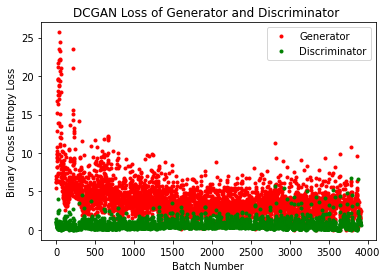

In [10]:
plt.plot(counter_list, gen_loss_list, 'r.', label='Generator')
plt.plot(counter_list, dis_loss_list, 'g.', label='Discriminator')
plt.title("DCGAN Loss of Generator and Discriminator ")
plt.xlabel("Batch Number")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend(loc="best")
plt.show()